<a href="https://colab.research.google.com/github/JunHL96/PyTorch-Course/blob/main/01_pytorch_workflow_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. PyTorch Workflow

Let's explore an example of a PyTorch end-to-end workflow

* Ground truth notebook: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow
* Book version of notebook: https://github.com/mrdbourke/pytorch-deep-learning-book/blob/main/01_pytorch_workflow
* Ask a question: https://github.com/mrdbourke/pytorch-deep-learning/discussions

## Example Workflow:

1. Get data ready (turn into tensors)
2. Build or pick a pretrained model (to suit your problem)
* 2.1) Pick a loss function & optimizer
* 2.2) Build a training loop
* 2.3) Repeat step 2 until ready to move to step 3
3. Fit the model to the data and make a prediction
4. Evaluate the model
5. Improve through experimentation
6. Save and reload your trained model.

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

print(f"Pytorch version: {torch.__version__}")

Pytorch version: 2.5.0+cu121


In [2]:
# Setup device-agnostic code
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")

Using device: cpu


In [3]:
what_we_are_covering = {1: "data (prepare and load)",
                        2: "build model",
                        3: "fitting the model to data (training)",
                        4: "making predictions and evaluating a model (inference)",
                        5: "saving and loading a model",
                        6: "putting it all together"}

what_we_are_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

## 1. Data (preparing and loading)

Data can be almost everything in ML:
* Excel spreadsheet
* Images of any kind
* Videos (YouTube has lots of data)
* Audio (Songs, podcasts, etc.)
* DNA
* Text

ML is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation.

![machine learning is a game of two parts: 1. turn your data into a representative set of numbers and 2. build or pick a model to learn the representation as best as possible](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-machine-learning-a-game-of-two-parts.png)

To showcase this, let's create some *known* data using the linear regression formula:

### Linear Regression Formula

Linear regression models the relationship between a dependent variable (target) and one or more independent variables (features). The formula is:

**y = β<sub>0</sub> + β<sub>1</sub>x<sub>1</sub> + β<sub>2</sub>x<sub>2</sub> + ... + β<sub>n</sub>x<sub>n</sub> + ε**

- **y**: The predicted output (dependent variable).
- **β<sub>0</sub>**: The intercept (constant term).
- **β<sub>1</sub>, β<sub>2</sub>, ..., β<sub>n</sub>**: Coefficients representing the impact of each independent variable (x<sub>1</sub>, x<sub>2</sub>, ..., x<sub>n</sub>).
- **x<sub>1</sub>, x<sub>2</sub>, ..., x<sub>n</sub>**: Independent variables (features).
- **ε**: Error term (difference between predicted and actual values).

In simple linear regression (one feature), the formula simplifies to:

**y = β<sub>0</sub> + β<sub>1</sub>x + ε**

We'll use a linear regression formula to make a straight line with *known* **parameters**.


In [4]:
# Create *known* parameters for linear regression
# The weight determines how much influence the input feature x has on the output y.
weight = 0.7  # The slope (coefficient) of the line (β₁ in y = β₀ + β₁x)
# The bias adjusts the output independently of the input x.
bias = 0.3    # The intercept (constant) of the line (β₀ in y = β₀ + β₁x)

# Create input data (X) for linear regression
start = 0     # Starting value of X (independent variable)
end = 1       # Ending value of X
step = 0.02   # Step size for generating values of X (i.e., increments of 0.02)
X = torch.arange(start, end, step).unsqueeze(dim=1)
# torch.arange creates a tensor with range of values from 0 to 0.98 (exclusive) with step size of 0.02
# unsqueeze adds a dimension to the tensor (makes it a column vector).
# - in this context, .unsqueeze(dim=1) adds a new dimension at index 1, transforming the tensor from a shape of [100] (1D) to [100, 1] (2D).

# Generate target values (y) using the linear regression formula
y = weight * X + bias  # This simulates a linear relationship between X and y (y = β₀ + β₁x)

# Output the first 10 values of X and y (input and output #s)
X[:10], y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concepts in ML in general)

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |

**Goal**: Generalization - The ability for a ML model to perform well on data it hasn't seen before.

In [6]:
# Create a train/test split

# Calculate the index to split the data (80% for training, 20% for testing)
train_split = int(0.8 * len(X))  # 80% of the length of the dataset will be for training
train_split  # This variable holds the index for splitting the data

# Split the data into training and testing sets
X_train, y_train = X[:train_split], y[:train_split]  # The first 80% of X and y for training
X_test, y_test = X[train_split:], y[train_split:]    # The remaining 20% of X and y for testing

# Output the lengths of the training and testing sets for verification (training split + test split))
len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [7]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data, and compares predictions if provided.

    Parameters:
    - train_data: The input features for training data (X_train).
    - train_labels: The corresponding target values for training data (y_train).
    - test_data: The input features for test data (X_test).
    - test_labels: The corresponding target values for test data (y_test).
    - predictions: The predicted values (optional) for the test data.
    """

    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    # `plt.scatter` creates a scatter plot for the training data (X_train, y_train) in blue (c="b").
    # `s=4` sets the size of the points to 4, and `label` adds a legend entry for the training data.

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")
    # Similarly, test data (X_test, y_test) is plotted in green (c="g") with a legend entry for the test data.

    # Plot predictions in red if they exist
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        # If predictions are provided, they are plotted in red (c="r").
        # This shows how the predicted values compare to the actual test data.

    # Plot a line of best fit (if predictions exist)
    if predictions is not None:
        plt.plot(test_data, predictions, c="r", label="Line of best fit")
        # `plt.plot` creates a line of best fit using the test data and the predictions.
        # This red line represents the linear relationship the model has learned.

     # Add legend and labels
    plt.legend(prop={"size": 14})  # Displays the legend with font size 14 to differentiate training, test data, and predictions.

    plt.xlabel("X")  # Labels the x-axis as "X" (the input feature).

    plt.ylabel("y")  # Labels the y-axis as "y" (the target/output variable).

    # The final plot will show:
    # - Training data in blue
    # - Test data in green
    # - Predictions and line of best fit (if provided) in red
    # With a larger, clearer legend to distinguish between these elements.


    # The final plot will show training data in blue, test data in green, and, if provided, predictions and the line of best fit in red.


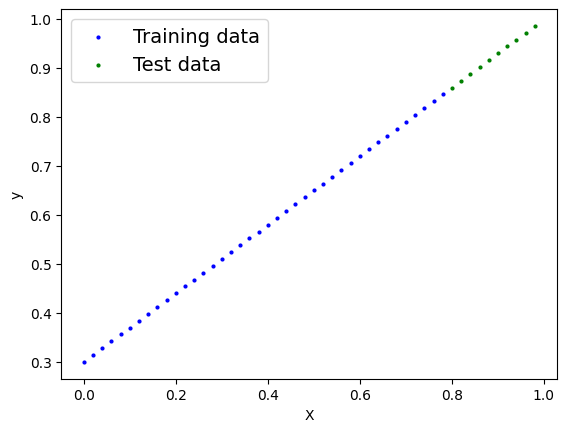

In [8]:
plot_predictions();

## 2. Build Model

Now that we've got some data, let's build a model to use the blue dots to predict the green dots.

This is where we will need OOP.

### What our model does (in the code below):
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight and bias values we used to create the data).

### How does it work?
Through two main algorithms:

1. **Gradient Descent**:
   - **Goal**: Gradient descent is an optimization algorithm that helps adjust the model’s parameters (weights and biases) to minimize a **loss function** (which tells us how far off our predictions are from the actual data). The lower the loss, the better the model is performing.
   - **Process**:
     1. **Start with random values**: The model begins with random values for its weights and biases.
     2. **Calculate the loss**: For every prediction the model makes, compare it to the actual data using a loss function like **Mean Squared Error (MSE)**. MSE measures how far the predicted values are from the actual values.
     3. **Compute the gradient**: In ML, gradient is a derivative of a function that has more than one input variable. Think of it as a slope or vector that is the measure of how much the loss will change if you adjust each of the parameters. Gradients point in the direction of increasing loss, so by following the opposite direction, we can reduce the loss.
     4. **Update parameters**: The model's weights and biases are updated by a small amount in the direction that reduces the loss. This process is repeated until the model's parameters settle at values that minimize the error.
     - **Key Idea**: We want to reduce the error between the predicted and actual values, so the weights and biases are adjusted iteratively by using gradients to guide those adjustments.
   
2. **Backpropagation**:
   - **Goal**: Backpropagation computes how much each parameter (weight and bias) contributed to the overall error (loss), so the model knows exactly how to adjust them.
   - **Process**:
     1. **Forward pass**: Input data passes through the network, layer by layer, and the model makes a prediction using the current weights and biases.
     2. **Calculate the loss**: The model compares the prediction to the actual data using the loss function (e.g., MSE) to determine how far off the prediction was.
     3. **Backward pass (Backpropagation)**: The loss is then “propagated backward” through the network by calculating how much each weight and bias influenced the loss. This is done using the **chain rule** from calculus, which breaks the error into pieces that allow the model to understand the impact of each parameter.
     4. **Gradient computation**: Backpropagation computes the gradient (or slope) of the loss function with respect to each parameter in the network, starting from the output layer and moving backward to the input layer.
     5. **Update parameters**: These gradients are then used by gradient descent to update the weights and biases in a way that reduces the error for the next prediction.

   - **Key Idea**: Backpropagation helps calculate the gradients needed to update each weight and bias by understanding how each one contributed to the error. This is critical for making the model learn.

### Relationship between loss function, backpropagation, and gradient descent

The **loss function** quantifies how far the model is from the optimal solution, **backpropagation** calculates the gradients of the loss function with respect to each model parameter by propagating the error backward through the network, and **gradient descent** is the mechanism that iteratively reduces this loss by updating the model parameters based on these gradients.

### Why backpropogation instead of calculating the error by propagating forward?

Backpropagation is preferred over forward propagation for calculating error because:

1. **Chain Rule of Calculus**:
   - Backpropagation uses the **chain rule** to compute how the loss changes with respect to each parameter, starting from the output layer and moving backward. This allows efficient gradient calculation for each layer.

2. **Final Error at Output**:
   - The error is only available at the **final output layer** after a forward pass. Backpropagation propagates this error backward to attribute it to earlier layers, adjusting their parameters accordingly.

3. **Parameter Dependencies**:
   - Each layer’s output affects subsequent layers, so backpropagation efficiently computes how each layer’s parameters contributed to the final error by propagating gradients from the output backward.

4. **Efficiency**:
   - Backpropagation avoids recalculating intermediate values by reusing the forward pass results, making it much more efficient than propagating gradients forward.

5. **Conclusion**:
   - Backpropagation efficiently calculates how each layer’s parameters contribute to the final error using the chain rule, starting from the output. Forward propagation computes predictions but cannot provide the necessary information to adjust parameters.

Think of Gradient Descent as a curved graph for each parameter:

![Gradient Descent Image](https://images.javatpoint.com/tutorial/machine-learning/images/gradient-descent-in-machine-learning2.png)

In [9]:
# Create a linear regression model class inheriting from nn.Module (the base class for all neural network modules)
class LinearRegressionModel(nn.Module):
    # Constructor method for the class. It's called when a new instance of the class is created.
    def __init__(self):
        # super will call the __init__ method of the parent class (nn.Module) to ensure that all its functionality is initialized
        super().__init__()
        # Define the weights parameter initialized randomly with requires_grad=True to compute gradients for optimization
        self.weight = nn.Parameter(torch.randn(1, # start with a random weight and try to adjust it to the ideal weight
                                                requires_grad=True, # This is true by default so we don't need to explicitly set it True here
                                                dtype=torch.float))  # <- This is float32 by default so we don't need to explicitly set it like this here

        # Define the bias parameter initialized randomly with requires_grad=True to compute gradients
        self.bias = nn.Parameter(torch.randn(1, # start with a random bias and try to adjust it to the ideal bias
                                             requires_grad=True,
                                             dtype=torch.float))

    # Forward method defines how input data x is transformed to produce the output data
    # Implements the forward pass, where 'x' is an input tensor and the output is a processed tensor, both of type torch.Tensor.
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Apply the linear regression formula y = wx + b
        return self.weight * x + self.bias

# The goal is to start with random weights and biases, run it through the forward pass,
# and then update the weights and biases to represent the known parameters (currently 0.7 and 0.3) as closely as possible
# Through an algorithm called gradient descent, this is achieved.

### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html). For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | This is a special kind of tensor that is specifically designed to be used as part of the learnable parameters in a neural network. It essentially stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  |
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. |
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). |
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data

![a pytorch linear model with annotations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)
*Basic building blocks of creating a PyTorch model by subclassing `nn.Module`. For objects that subclass `nn.Module`, the `forward()` method must be defined.*

> **Resource:** See more of these essential modules and their use cases in the [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html).


### Checking the contents of our PyTorch model

Now that we've created a model, let's see what is inside

We can check out our model parameters using `.parameters()`.


In [10]:
# Set a fixed seed for reproducibility (ensures the same random numbers are generated each time)
torch.manual_seed(42)

# Instantiate the linear regression model (this creates an instance with random weight and bias)
model_0 = LinearRegressionModel()

# Retrieve the list of parameters (weights and biases) of the model for inspection
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can also get the state (what the model contains) of the model using [`.state_dict()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.state_dict).

In [11]:
# List named parameters and their corresponding values
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])


Notice how the values for `weights` and `bias` from `model_0.state_dict()` come out as random float tensors?

This is because we initialized them above using `torch.randn()`.

Essentially we want to start from random parameters and get the model to update them towards parameters that fit our data best (the hardcoded `weight` and `bias` values we set when creating our straight line data). In this case, that would be 0.7 and 0.3 for weight and bias respectively.

> **Exercise:** Try changing the `torch.manual_seed()` value two cells above, see what happens to the weights and bias values.

Because our model starts with random values, right now it'll have poor predictive power.



### Making predictions with using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data to our model, it will go through the model's `forward()` method and produce a result using the computation we've defined.

In [12]:
X_test, y_test
# An ideal model will input X_test and output y_test values exactly, i.e., the model should have no error

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [13]:
# Make predictions with model
with torch.inference_mode():
    y_pred = model_0(X_test) # we pass the X_test data through our model

# Note that inference mode temporarily disables autograd, which can speed up prediction computations

# Inference mode is preferred over no_grad mode because it saves memory and speeds up computations, especially when dealing with large datasets.

y_pred

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

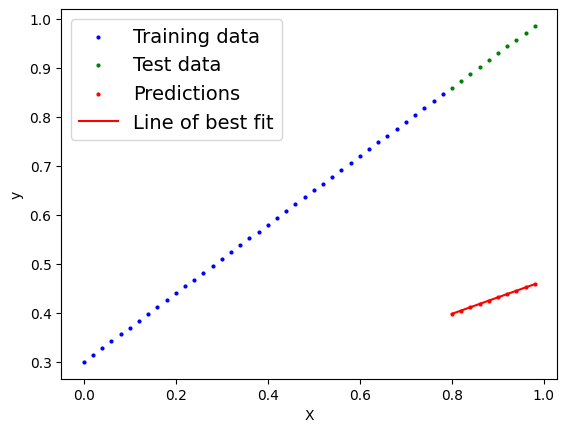

In [14]:
plot_predictions(predictions=y_pred)

Currently, our model is making random predictions that are far from where our data actually lies. This is because we haven't trained our model yet.

Right now, our model is making predictions using random parameters to make calculations (random guessing). It's not looking at the blue dots to predict the green dots at all.

## 3. Train Model

Right now, our model is making prediction using random parameters to make calculations. It is basically guessing randomly.

We could attempt to hard-code the ideal values, but most of the time we would not know what the ideal parameters are for a model.

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters i.e. from a poor representation of the data to a better representation of the data.

One way to measure how inaccurate or how wrong your model's predictions are is to use a loss function.

### Creating a loss function and optimizer in PyTorch

| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong your model's predictions (e.g. `y_pred`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  |
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). |

Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another).

For our problem, since we're predicting a number, let's use MAE (which is under `torch.nn.L1Loss()`) in PyTorch as our loss function.

![what MAE loss looks like for our plot data](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-mae-loss-annotated.png)
*Mean absolute error (MAE, in PyTorch: `torch.nn.L1Loss`) measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.*

And we'll use SGD, `torch.optim.SGD(params, lr)` where:

* `params` is the target model parameters you'd like to optimize (e.g. the `weights` and `bias` values we randomly set before).
* `lr` is the **learning rate** you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a **hyperparameter** (because it's set by a machine learning engineer). Common starting values for the learning rate are `0.01`, `0.001`, `0.0001`, however, these can also be adjusted over time (this is called [learning rate scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)).


### Code Implementation:

In [15]:
# Create a loss function using L1 Loss (MAE), which calculates the absolute differences between predicted and target values
loss_fn = nn.L1Loss()

# Create the optimizer using Stochastic Gradient Descent (SGD), with the model's parameters and a learning rate of 0.01
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of the target model to optimize
                            lr=0.01) # learning rate: how much the optimizer should change parameters at each step.
                                     # higher=more (less stable), lower=less (more stable)

### Creating an optimization loop in PyTorch

Now that we have a loss function and an optimizer, now we can create a **training loop** (and **testing loop**)

The **training loop** involves the model going through the training data and learning the relationships between the `features` and `labels`.

The **testing loop** involves evaluating how well the model has learned patterns from the training data by using the testing data, which the model has not seen during training.

### PyTorch training loop
| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` |
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

![pytorch training loop annotated](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

> **Note:** The above is just one example of how the steps could be ordered or described. With experience you'll find making PyTorch training loops can be quite flexible.
>
> And on the ordering of things, the above is a good default order but you may see slightly different orders. Some rules of thumb:
> * Calculate the loss (`loss = ...`) *before* performing backpropagation on it (`loss.backward()`).
> * Zero gradients (`optimizer.zero_grad()`) *before* computing the gradients of the loss with respect to every model parameter (`loss.backward()`).
> * Step the optimizer (`optimizer.step()`) *after* performing backpropagation on the loss (`loss.backward()`).



### PyTorch testing loop

As for the testing loop (evaluating our model), the typical steps include:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the testing data once, performing its `forward()` function calculations. | `model(x_test)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)` |
| 3 | Calulate evaluation metrics (optional) | Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |

Notice the testing loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.

![pytorch annotated testing loop](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-testing-loop-annotated.png)


### What are Loss Values?

Loss values are a way to measure how well a machine learning model's predictions match the actual target values. In simple terms, they tell you how far off your model's predictions are from the correct answers.

#### Key Points:

1. **Quantifying Error**:
   The loss function calculates the difference (error) between the model’s predicted output and the actual target (true) output.
   - For example, in regression tasks, if the model predicts a value like 20 but the actual value is 25, the loss function measures the size of this error.

2. **Single Number**:
   The result of this calculation is a single number that represents how poorly or well the model is performing. Lower loss means better performance (i.e., smaller error), and higher loss means worse performance.

3. **Training Loss vs. Testing Loss**:
   - **Training Loss**: The loss calculated on the training dataset, which the model learns from.
   - **Testing Loss**: The loss calculated on the test (or validation) dataset, which is unseen by the model during training. This helps evaluate how well the model generalizes to new data.

4. **Loss Function**:
   The specific way in which the loss is calculated depends on the type of task. Common loss functions include:
   - **Mean Squared Error (MSE)**: Used for regression tasks, it calculates the average squared difference between predicted and actual values.
   - **Cross-Entropy Loss**: Used for classification tasks, it measures the difference between predicted probability distributions and actual class labels.

In short, **loss values guide the model in learning**. During training, the model adjusts its parameters (weights and biases) to minimize the loss, which improves its predictions.

### Writing the code to train and test our model:

In [16]:
torch.manual_seed(42)  # Set random seed for reproducibility

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 200

# Create empty lists to track loss values for both training and testing data
train_loss_values = []  # Stores the loss values for the training dataset
test_loss_values = []   # Stores the loss values for the testing dataset
epoch_count = []        # Tracks the epochs when losses are recorded

### Training the model

for epoch in range(epochs):
    ### Training

    # Set the model to training mode (enables gradient calculation, and if using layers like dropout, they behave correctly for training)
    model_0.train()

    # 1. Forward pass on training data to get predictions (model processes the input data X_train and generates output predictions y_pred)
    y_pred = model_0(X_train)

    # 2. Calculate training loss (loss_fn compares the predicted values (y_pred) to the actual target values (y_train) to quantify the error)
    loss = loss_fn(y_pred, y_train) # loss_fn(prediction, target)

    # 3. Zero the gradients (clears old gradients from previous iterations, preventing accumulation that would mess up the updates)
    optimizer.zero_grad()

    # 4. Backpropagate the loss (calculates how the loss changes with respect to each model parameter using the chain rule)
    loss.backward()

    # 5. Update model parameters based on calculated gradients (optimizer adjusts model weights in the direction that reduces the loss)
    optimizer.step() # this should always go after backpropagation

### Testing the model (with data it has never seen before)

    # Set the model to evaluation mode (disables gradient calculation and sets dropout layers to inference mode)
    model_0.eval()

    with torch.inference_mode():  # Disable gradient calculation for efficiency during evaluation/testing
        # 1. Forward pass on test data to get predictions (assess model performance on unseen data)
        test_pred = model_0(X_test)

        # 2. Calculate testing loss (quantifies how far off predictions are from actual values in test data)
        test_loss = loss_fn(test_pred, y_test)

        # Log and print progress every 10 epochs
        if epoch % 10 == 0:
            epoch_count.append(epoch)  # Track current epoch number
            train_loss_values.append(loss.detach().numpy())  # Save training loss (detach to prevent storing gradients)
            test_loss_values.append(test_loss.detach().numpy())  # Save testing loss
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")
            print(model_0.state_dict())

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
OrderedDict([('weight', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
OrderedDict([('weight', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
OrderedDict([('weight', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
OrderedDict([('weight', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
OrderedDict([('weight', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
OrderedDict([('weight', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE 

> **Note:** Due to the random nature of machine learning, you will likely get slightly different results (different loss and prediction values) depending on whether your model was trained on CPU or GPU. This is true even if you use the same random seed on either device. If the difference is large, you may want to look for errors, however, if it is small (ideally it is), you can ignore it.

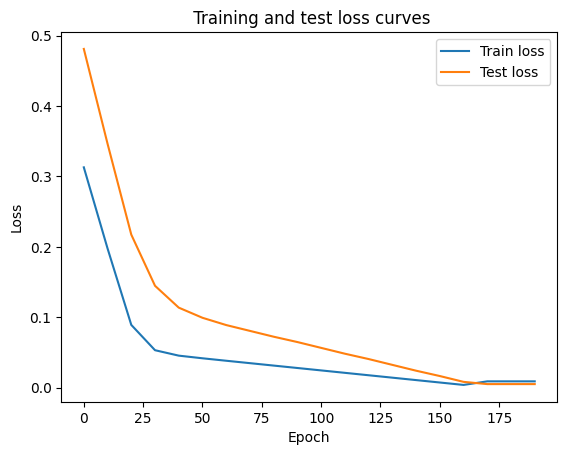

In [17]:
# Plot the loss curves - this is one way we can keep track of our model's training and testing performance
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title(" Training and test loss curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

> Note that the loss does go down for both in increments (gradient descent).

In [18]:
# Import the pprint function to pretty-print the model's state dictionary for improved readability
from pprint import pprint

# Print a message to indicate that the following output shows the model's learned parameters (weights and bias) after training
print("The model learned the following values for weights and bias:")

# Pretty-print the model's state dictionary, which contains the learned weights and bias after training
pprint(model_0.state_dict())

# Print a message to indicate that the next output will show the original, pre-training values for weights and bias
print("\nAnd the original values for weights and bias are:")

# Print the original values for weights and bias (initial values before any training)
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


Try changing to `epochs` from 100 to a higher number and note how the loss curves and the weights and bias parameter values change.

Instead of hard-coding the ideal weight and bias, we trained a model to figure them out.

## 4. Making predictions with a trained PyTorch model (inference)

Once you've trained a model, you'll likely want to make predictions with it.

We've already seen a glimpse of this in the training and testing code above, the steps to do it outside of the training/testing loop are similar.

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

1. Set the model in evaluation mode (`model.eval()`).
2. Make the predictions using the inference mode context manager (`with torch.inference_mode(): ...`).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

The first two items make sure all helpful calculations and settings PyTorch uses behind the scenes during training but aren't necessary for inference are turned off (this results in faster computation). And the third ensures that you won't run into cross-device errors.

In [19]:
# Set the model in evaluation mode. This is done to ensure that the model is in the correct mode for inference
model_0.eval()

# Setup the inference mode context manager.This context manager ensures that all calculations within it are done in inference mode
with torch.inference_mode():
    # Make sure the calculations are done with the model and data on the same device
    # - in this specific example, the data and model are on the CPU by default

    # Using device agnostic code. Comment out if you don't have a GPU
    #model_0.to(device)
    #X_test = X_test.to(device)

    # Perform the inference using the model and data. The output of the model is stored in the variable y_pred
    y_pred = model_0(X_test)

# Print the output of the model
y_pred

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

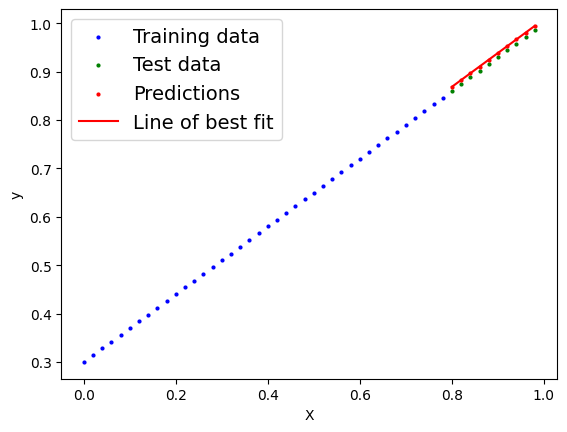

In [20]:
plot_predictions(predictions=y_pred)

We have reduced the difference between our model's predictions and the ideal outcomes.

## 5. Saving and loading a PyTorch model

If you've trained a PyTorch model, then you'd likely want to save it and export it somewhere; you have a trained model you'd like to export to some sort of application where others can use it.

For saving and loading models in PyTorch, there are three main methods to be aware of:

| PyTorch method | What does it do? |
| ----- | ----- |
| [`torch.save`](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save) | Saves a serialized object to disk using Python's [`pickle`](https://docs.python.org/3/library/pickle.html) utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`.  |
| [`torch.load`](https://pytorch.org/docs/stable/torch.html?highlight=torch%20load#torch.load) | Uses `pickle`'s unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc). |
| [`torch.nn.Module.load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=load_state_dict#torch.nn.Module.load_state_dict)| Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object. |


> **Note:** As stated in [Python's `pickle` documentation](https://docs.python.org/3/library/pickle.html), the `pickle` module **is not secure**. That means you should only ever unpickle (load) data you trust. That goes for loading PyTorch models as well. Only ever use saved PyTorch models from sources you trust.

### Saving a PyTorch model's `state_dict()`

The [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

Let's see how we can do that in a few steps:

1. We'll create a directory for saving models to called `models` using Python's `pathlib` module.
2. We'll create a file path to save the model to.
3. We'll call `torch.save(obj, f)` where `obj` is the target model's `state_dict()` and `f` is the filename of where to save the model.

> **Note:** It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`, like `saved_model_01.pth`.

### Additional Explanations

#### Why Save Only the `state_dict()`?
- **Efficiency**: Saving the `state_dict()` is more efficient and faster compared to saving the entire model because it only saves the model parameters (weights and biases), not the architecture. This allows you to change or modify the model architecture later if needed.
- **Flexibility**: When loading a model for inference or further training, defining the model class separately and loading the `state_dict()` makes it easier to use the saved model in different scripts or projects without worrying about architecture dependencies.

#### Saving Model Checkpoints
It’s common to save checkpoints during training to resume later or choose the best-performing model. In these cases, you can save both the `state_dict()` and optimizer’s `state_dict()`.

### Key Points:
- **Directory Creation**: `Path.mkdir(exist_ok=True)` ensures the directory is created if it doesn’t exist already.
- **Saving**: `torch.save(model.state_dict(), model_save_path)` saves the model parameters, but not the model architecture.
- **Extensions**: Common extensions for PyTorch models are `.pth` or `.pt`.

In [21]:
from pathlib import Path  # Import the Path class from the pathlib module for handling file and directory paths in an OS-independent manner.

# 1. Create models directory. Define the directory path for saving the model.
MODEL_PATH = Path("models") # Save our models to a new folder called "models"
MODEL_PATH.mkdir(parents=True, # 'parents=True' ensures that any missing parent directories are created.
                 exist_ok=True) # 'exist_ok=True' prevents an error if the directory already exists.

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth" # Define the filename for saving the model.
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME # Use the '/' operator to join the directory path and the filename.

# 3. Save the model state dictionary to the save path
print(f"Saving model to: {MODEL_SAVE_PATH}") # Print the path where the model is being saved.
torch.save(obj=model_0.state_dict(), # Use torch.save() to save the model's state_dict (parameters) to the specified path.
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


If you check the VSCode explorer tab, you’ll notice that a new folder named models has been created, and inside it, you’ll find the saved model file.

In [22]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1680 Nov  1 19:47 models/01_pytorch_workflow_model_0.pth


### Loading a saved PyTorch model's `state_dict()`

Since we've now got a saved model `state_dict()` at `models/01_pytorch_workflow_model_0.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`.

Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`?

Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the *entire* model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).

Why not save the entire model?

[Saving the entire model](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model) rather than just the `state_dict()` is more intuitive, however, to quote the PyTorch documentation (italics mine):

> The disadvantage of this approach *(saving the whole model)* is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...
>
> Because of this, your code can break in various ways when used in other projects or after refactors.

So instead, we're using the flexible method of saving and loading just the `state_dict()`, which again is basically a dictionary of model parameters.

Let's test it out by creating another instance of `LinearRegressionModel()`, which is a subclass of `torch.nn.Module` and will hence have the in-built method `load_state_dict()`.

In [23]:
# Instantiate a new instance of the model (this creates an untrained model with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the trained state_dict (a dictionary containing model parameters such as weights and biases)
# The state_dict was saved after training, and now we're loading it into the new model instance
# This effectively transfers the learned parameters to the new model, allowing it to make predictions as if it had been trained with the same data.
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-23-af0f6e9d1a07>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

Now to test our loaded model, let's perform inference with it (make predictions) on the test data.

Remember the rules for performing inference with PyTorch models?

If not, here's a refresher:

<details>
    <summary>PyTorch inference rules</summary>
    <ol>
      <li> Set the model in evaluation mode (<code>model.eval()</code>). </li>
      <li> Make the predictions using the inference mode context manager (<code>with torch.inference_mode(): ...</code>). </li>
      <li> All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).</li>
    </ol>
</details>

In [24]:
# 1. Put the loaded model into evaluation mode (we need to do this to make predictions)
# This disables layers like dropout and batch normalization, ensuring consistent predictions.
loaded_model_0.eval()

# 2. Use the inference mode context manager
# Inference mode disables gradient calculation to save memory and improve performance, since we don't need backpropagation during prediction.
with torch.inference_mode():
    # Perform a forward pass on the test data to make predictions using the loaded model
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

Now we've made some predictions with the loaded model, let's see if they're the same as the previous predictions.


In [25]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_pred == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

Nice!

It looks like the loaded model predictions are the same as the previous model predictions (predictions made prior to saving). This indicates our model is saving and loading as expected.

> **Note:** There are more methods to save and load PyTorch models but those are extra-curriculum. See the [PyTorch guide for saving and loading models](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-and-loading-models) for more.

## 6. Putting it all together

This section will be dedicated to putting into practice everything covered thus far. However, we will also add our device-agnostic code to the code this time around to accelerate tasks that can be done faster with GPU.

In [26]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.0+cu121'

In [27]:
# Setup device-agnostic code
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple Silicon GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")

Using device: cpu


### 6.1 Data

Let's create some data just like before.

First, we'll hard-code some `weight` and `bias` values.

Then we'll make a range of numbers between 0 and 1, these will be our `X` values.

Finally, we'll use the `X` values, as well as the `weight` and `bias` values to create `y` using the linear regression formula (`y = weight * X + bias`).

In [28]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Now we've got some data, let's split it into training and test sets.

We'll use an 80/20 split with 80% training data and 20% testing data.

In [29]:
# Split data
train_split = int(0.8 * len(X)) # returns the # of elements in the tensor
X_train, y_train = X[:train_split], y[:train_split]  # The first 80% of X and y for training
X_test, y_test = X[train_split:], y[train_split:]    # The remaining 20% of X and y for testing

len(X_train), len(X_test), len(y_train), len(y_test) # check to see if the split is correct

(40, 10, 40, 10)

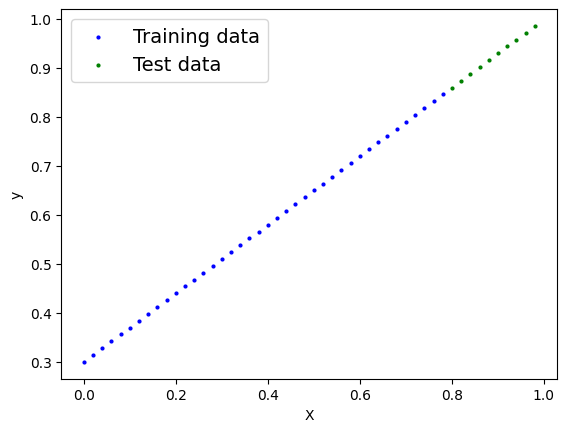

In [30]:
# Plot the data
# Note: if you've reset your runtime, this function won't work, you'll have to rerun the cell far above where we wrote this function

plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch linear model

We've got some data, now it's time to make a model.

We'll create the same style of model as before except this time, instead of defining the weight and bias parameters of our model manually using `nn.Parameter()`, we'll use [`nn.Linear(in_features, out_features)`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to do it for us.

Where `in_features` is the number of dimensions your input data has and `out_features` is the number of dimensions you'd like it to be output to.

In our case, both of these are `1` since our data has `1` input feature (`X`) per label (`y`).

![comparison of nn.Parameter Linear Regression model and nn.Linear Linear Regression model](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-regression-model-with-nn-Parameter-and-nn-Linear-compared.png)
*Creating a linear regression model using `nn.Parameter` versus using `nn.Linear`. There are plenty more examples of where the `torch.nn` module has pre-built computations, including many popular and useful neural network layers.*

In [31]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):     # Constructor method for the class. It's called when a new instance of the class is created.
        super().__init__()  # Calls the __init__ method of the parent class (nn.Module) to initialize all its functionality

        # Instead of manually setting the parameters (weight and bias), we'll use nn.Linear to define our layer.
        # nn.Linear is a pre-built layer in PyTorch for creating a linear transformation.

        self.linear_layer = nn.Linear(in_features=1, # The number of input features (in this case, 1 because we have one input variable X)
                                      out_features=1) # The number of output features (in this case, 1 because we want a single output y)

        # Explanation of nn.Linear:
        # - nn.Linear automatically initializes a weight and a bias for the linear transformation.
        # - In a linear regression model, this layer will apply the equation: y = weight * X + bias
        # - Since we’re only dealing with one input and one output, we set in_features=1 and out_features=1.

        # After initializing, self.linear_layer will be a layer in our model that automatically performs the linear transformation.

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # The forward method defines the "forward pass" or the computation step of the model.

        # x: torch.Tensor
        # - The parameter `x` is a tensor (array) containing the input data to be passed into the model.
        # - In PyTorch, `torch.Tensor` represents a multi-dimensional array (tensor) used for storing data.
        # - Here, `x` will contain the feature values (the input variable X for linear regression).

        # return self.linear_layer(x)
        # - This line passes the input tensor `x` through the linear layer we defined (self.linear_layer).
        # - `self.linear_layer(x)` applies the linear transformation, resulting in an output tensor.
        # - The output tensor will have the predicted values based on the learned weight and bias.

        return self.linear_layer(x)  # Returns the transformed tensor, representing our model's predictions

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

`nn.Linear` documentation: [PyTorch nn.Linear Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

Notice how `nn.Linear` aligns perfectly with the concept of linear regression: it performs a simple linear transformation with a weight and bias, just like the equation for linear regression, $y = \text{weight} \times X + \text{bias}$.

In PyTorch, instead of manually initializing the parameters (like weight and bias), we typically define **layers** (such as `nn.Linear` for linear transformations) and let PyTorch handle the initialization. Then, we use these layers to perform calculations in the **forward pass** of our model.

This approach allows us to work with both simple models, like linear regression, and more complex neural networks by building a sequence of layers that PyTorch will optimize and train.

In [32]:
# Set model to GPU, otherwise it runs on CPU
model_1.to(device)  # Moves the model (model_1) to the specified device (e.g., 'cuda', 'mps', or 'cpu') for computation.
next(model_1.parameters()).device  # Checks and returns the device where the first parameter of the model is currently located.

device(type='cpu')

### 6.3 Training

Time to build a training and testing loop.

First we'll need a loss function and an optimizer (using gradient descent).

Let's use the same functions we used earlier, `nn.L1Loss()` and `torch.optim.SGD()`.

We'll have to pass the new model's parameters (`model.parameters()`) to the optimizer for it to adjust them during training.

The learning rate of `0.01` worked well before too so let's use that again.


In [33]:
# Create loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # parameters of target model to optimize
                            lr=0.01)                     # learning rate (how much the optimizer should change parameters at each step)

In [34]:
torch.manual_seed(42)  # Sets the random seed for reproducibility of results

# PyTorch Training Loop

epochs = 1000  # Number of training iterations
# Put data on the specified device (e.g., 'cuda', 'mps', or 'cpu') to avoid device mismatch errors
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()  # Sets the model to training mode (enables dropout, batchnorm updates, etc.)

    # 1. Forward pass: Compute model predictions for the training data
    y_pred = model_1(X_train)  # Input: X_train; Output: predicted values (tensor)

    # 2. Calculate loss: Measure how far predictions are from the true targets
    loss = loss_fn(y_pred, y_train)  # Input: (predictions, true targets); Output: loss value (scalar)

    # 3. Zero grad optimizer: Clear previous gradients to prevent accumulation
    optimizer.zero_grad()  # Resets gradients for all model parameters

    # 4. Loss backward: Compute gradients of the loss w.r.t. each model parameter
    loss.backward()  # Backpropagates the loss; modifies `.grad` attributes of parameters

    # 5. Step the optimizer: Update model parameters using the computed gradients
    optimizer.step()  # Adjusts parameters to minimize the loss

    ### Testing
    model_1.eval()  # Sets the model to evaluation mode (disables dropout, batchnorm updates)

    # 1. Forward pass (inference): Compute predictions for test data without tracking gradients
    with torch.inference_mode():  # Disables gradient tracking for faster and memory-efficient inference
        test_pred = model_1(X_test)  # Input: X_test; Output: predicted values (tensor)

    # 2. Calculate test loss: Compare predictions with true test targets
    test_loss = loss_fn(test_pred, y_test)  # Input: (predictions, true targets); Output: test loss value (scalar)

    # Print loss values every 10 epochs for tracking progress
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.item()} | Test loss: {test_loss.item()}")
        # print(...)                    # Prints the formatted string to the console.
        # f"..."                        # An f-string allows embedding expressions inside string literals for formatting.
        # Epoch: {epoch}                # Displays the current epoch number (variable `epoch`).
        # | Loss: {loss.item()}         # Shows the training loss. `loss.item()` extracts the value from the tensor `loss` as a standard Python number.
        # | Test loss: {test_loss.item()} # Shows the test loss. `test_loss.item()` extracts the value from the tensor `test_loss` as a Python number.

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.4399680495262146 | Test loss: 0.4392663538455963
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954827964305878 | Test loss: 0.16984674334526062
Epoch: 40 | Loss: 0.09433844685554504 | Test loss: 0.03513689711689949
Epoch: 50 | Loss: 0.023886386305093765 | Test loss: 0.04784906655550003
Epoch: 60 | Loss: 0.0199567973613739 | Test loss: 0.04580312222242355
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.0375305712223053
Epoch: 80 | Loss: 0.013089170679450035 | Test loss: 0.029944902285933495
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215679459273815 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.002787243574857712 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.01380180753767

> **Note:** Due to the random nature of machine learning, you will likely get slightly different results (different loss and prediction values) depending on whether your model was trained on CPU or GPU. This is true even if you use the same random seed on either device. If the difference is large, you may want to look for errors, however, if it is small (ideally it is), you can ignore it.

Nice! That loss looks pretty low.

Let's check the parameters our model has learned and compare them to the original parameters we hard-coded.

We can do this with `state.dict()`

In [35]:
# Find our model's learned parameters
from pprint import pprint
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

And the original values for weights and bias:
weights: 0.7, bias: 0.3


### Making Predictions

Now that we've got a trained model, let's turn on its evaluation mode and make some predictions.

Remember: evaluation mode is when the model is set to `.eval()`, which turns off certain layers like dropout and batch normalization to ensure consistent and reliable predictions during inference.

In [36]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_pred = model_1(X_test)
y_pred

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

Now let's plot our model's predictions.

> **Note:** Many data science libraries such as pandas, matplotlib and NumPy aren't capable of using data that is stored on GPU. So you might run into some issues when trying to use a function from one of these libraries with tensor data not stored on the CPU. To fix this, you can call [`.cpu()`](https://pytorch.org/docs/stable/generated/torch.Tensor.cpu.html) on your target tensor to return a copy of your target tensor on the CPU.

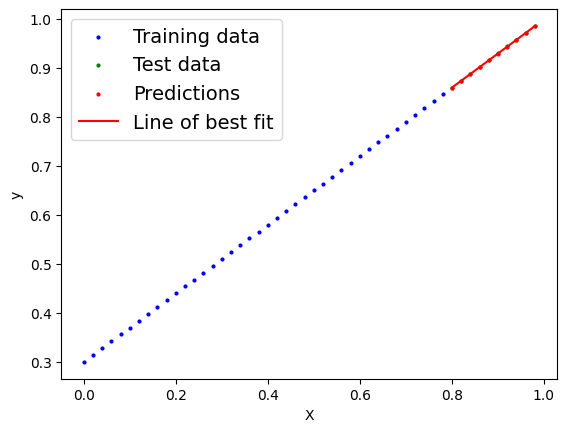

In [37]:
# plot_predictions(predictions=y_preds) # -> since data is not on CPU, this won't work

# Put data on the CPU and plot it
plot_predictions(predictions=y_pred.cpu())

### 6.5 Saving and loading a model

Save the model so that it can be used later.

In [38]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


And just to make sure everything worked well, let's load it back in.

We'll:
* Create a new instance of the `LinearRegressionModelV2()` class
* Load in the model state dict using `torch.nn.Module.load_state_dict()`
* Send the new instance of the model to the target device (to ensure our code is device-agnostic)

In [39]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cpu


<ipython-input-39-c4e3cba863db>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


Now we can evaluate the loaded model to see if its predictions line up with the predictions made prior to saving.

In [40]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_pred == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Exercises

All exercises have been inspired from code throughout the notebook.

There is one exercise per major section.

You should be able to complete them by referencing their specific section.

> **Note:** For all exercises, your code should be device agnostic (meaning it could run on CPU or GPU if it's available).

1. Create a straight line dataset using the linear regression formula (`weight * X + bias`).
  * Set `weight=0.3` and `bias=0.9` there should be at least 100 datapoints total.
  * Split the data into 80% training, 20% testing.
  * Plot the training and testing data so it becomes visual.
2. Build a PyTorch model by subclassing `nn.Module`.
  * Inside should be a randomly initialized `nn.Parameter()` with `requires_grad=True`, one for `weights` and one for `bias`.
  * Implement the `forward()` method to compute the linear regression function you used to create the dataset in 1.
  * Once you've constructed the model, make an instance of it and check its `state_dict()`.
  * **Note:** If you'd like to use `nn.Linear()` instead of `nn.Parameter()` you can.
3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively.
  * Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
  * Write a training loop to perform the appropriate training steps for 300 epochs.
  * The training loop should test the model on the test dataset every 20 epochs.
4. Make predictions with the trained model on the test data.
  * Visualize these predictions against the original training and testing data (**note:** you may need to make sure the predictions are *not* on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).
5. Save your trained model's `state_dict()` to file.
  * Create a new instance of your model class you made in 2. and load in the `state_dict()` you just saved to it.
  * Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

> **Resource:** See the [exercises notebooks templates](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/exercises) and [solutions](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions) on the course GitHub.

## Extra-curriculum
* Listen to [The Unofficial PyTorch Optimization Loop Song](https://youtu.be/Nutpusq_AFw) (to help remember the steps in a PyTorch training/testing loop).
* Read [What is `torch.nn`, really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html) by Jeremy Howard for a deeper understanding of how one of the most important modules in PyTorch works.
* Spend 10-minutes scrolling through and checking out the [PyTorch documentation cheatsheet](https://pytorch.org/tutorials/beginner/ptcheat.html) for all of the different PyTorch modules you might come across.
* Spend 10-minutes reading the [loading and saving documentation on the PyTorch website](https://pytorch.org/tutorials/beginner/saving_loading_models.html) to become more familiar with the different saving and loading options in PyTorch.
* Spend 1-2 hours reading/watching the following for an overview of the internals of gradient descent and backpropagation, the two main algorithms that have been working in the background to help our model learn.
 * [Wikipedia page for gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)
 * [Gradient Descent Algorithm — a deep dive](https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21) by Robert Kwiatkowski
 * [Gradient descent, how neural networks learn video](https://youtu.be/IHZwWFHWa-w) by 3Blue1Brown
 * [What is backpropagation really doing?](https://youtu.be/Ilg3gGewQ5U) video by 3Blue1Brown
 * [Backpropagation Wikipedia Page](https://en.wikipedia.org/wiki/Backpropagation)
